In [1]:
! pip install deep-utils
! pip install datasets

! pip install transformers[torch]
! pip install accelerate -U
!pip install scipy pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.1/529.1 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.4 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.26.1
    Uninstalling accelerate-0.26.1:
      Successfully uninstalled accelerate-0.26.1


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import pywt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from deep_utils import warmup_cosine

from datasets import load_dataset, Audio, Dataset
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

import warnings

warnings.filterwarnings("ignore")

2024-02-14 18:27:32.147409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 18:27:32.147530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 18:27:32.436473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_csv("/kaggle/input/biomed-datathon-bmefest2/train.csv")
train.head()

,patient_id,AS,AR,MR,MS,N,recording_1,recording_2,recording_3,recording_4,recording_5,recording_6,recording_7,recording_8
0,patient_052,0,1,0,0,0,052_sup_Mit,052_sup_Tri,052_sup_Pul,052_sup_Aor,052_sit_Mit,052_sit_Tri,052_sit_Pul,052_sit_Aor
1,patient_058,0,1,0,0,0,058_sup_Mit,058_sup_Tri,058_sup_Pul,058_sup_Aor,058_sit_Mit,058_sit_Tri,058_sit_Pul,058_sit_Aor
2,patient_068,0,1,0,0,0,068_sup_Mit,068_sup_Tri,068_sup_Pul,068_sup_Aor,068_sit_Mit,068_sit_Tri,068_sit_Pul,068_sit_Aor
3,patient_074,0,1,0,0,0,074_sup_Mit,074_sup_Tri,074_sup_Pul,074_sup_Aor,074_sit_Mit,074_sit_Tri,074_sit_Pul,074_sit_Aor
4,patient_054,1,0,0,0,0,054_sup_Mit,054_sup_Tri,054_sup_Pul,054_sup_Aor,054_sit_Mit,054_sit_Tri,054_sit_Pul,054_sit_Aor


In [4]:
patient_id_to_drop = "patient_085"
train = train[train["patient_id"] != patient_id_to_drop]

In [5]:
label_encoder = LabelEncoder()
train["labels"] = label_encoder.fit_transform(
    np.argmax(train[["AS", "AR", "MR", "MS", "N"]], axis=1)
)
train.drop(
    [
        "AS",
        "AR",
        "MR",
        "MS",
        "N",
        "recording_1",
        "recording_2",
        "recording_3",
        "recording_4",
        "recording_5",
        "recording_6",
        "recording_7",
        "recording_8",
    ],
    axis=1,
    inplace=True,
)
train.head()

,patient_id,labels
0,patient_052,1
1,patient_058,1
2,patient_068,1
3,patient_074,1
4,patient_054,0


In [6]:
train.labels.value_counts()

labels
0    19
4    12
2    11
1    10
3     6
Name: count, dtype: int64

In [9]:
import scipy.io.wavfile as wavfile


def remove_noise_heart_sound(audio_signal, sample_rate):
    nyquist_freq = 1 * sample_rate
    low_cutoff = 20
    high_cutoff = 2000
    filter_order = 3
    b, a = signal.butter(
        filter_order,
        [low_cutoff / nyquist_freq, high_cutoff / nyquist_freq],
        btype="band",
    )
    filtered_signal = signal.filtfilt(b, a, audio_signal)

    wavelet = "db4"
    threshold = 0.2
    coefficients = pywt.wavedec(filtered_signal, wavelet)
    coefficients[1:] = (
        pywt.threshold(detail, threshold * max(detail)) for detail in coefficients[1:]
    )
    denoised_signal = pywt.waverec(coefficients, wavelet)

    return denoised_signal


def denoise_audio_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(input_folder, filename)
            audio_signal, sample_rate = librosa.load(file_path, sr=None)

            denoised_signal = remove_noise_heart_sound(audio_signal, sample_rate)
            output_path = os.path.join(output_folder, filename)

            wavfile.write(output_path, sample_rate, denoised_signal)

In [10]:
input_folder = "/kaggle/input/bio-med-merged"
output_folder = "/kaggle/working/train_denoised"
denoise_audio_files(input_folder, output_folder)

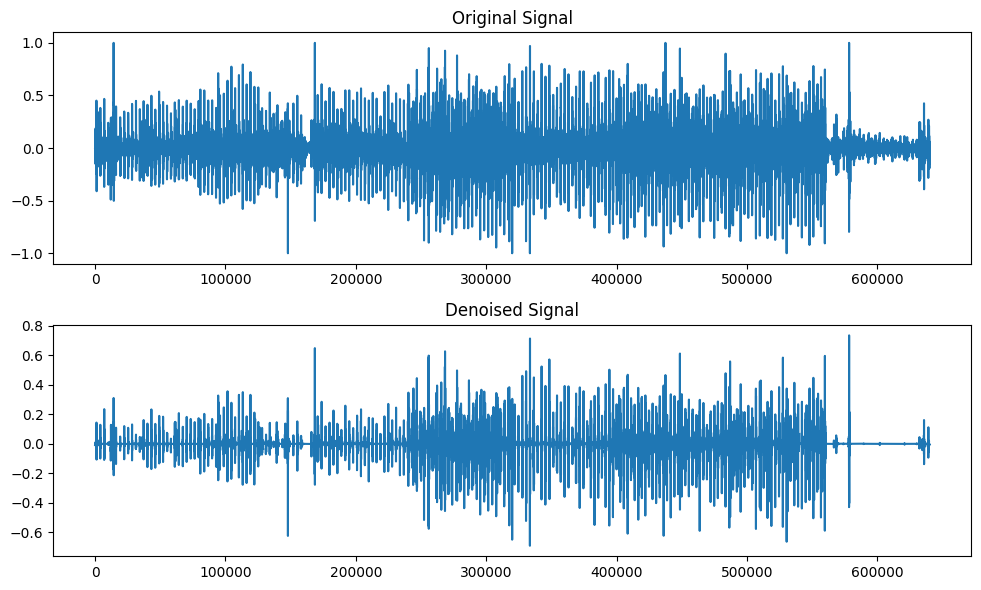

In [12]:
audio_signal, sample_rate = librosa.load(
    "/kaggle/input/bio-med-merged/patient_071.wav", sr=None
)
denoised_signal = remove_noise_heart_sound(audio_signal, sample_rate)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_signal)
plt.title("Original Signal")
plt.subplot(2, 1, 2)
plt.plot(denoised_signal)
plt.title("Denoised Signal")
plt.tight_layout()
plt.show()

In [13]:
BASE_URL = "/kaggle/working/train_denoised/"
train["path"] = train["patient_id"].apply(lambda x: BASE_URL + x + ".wav")
train["audio"] = train["patient_id"].apply(lambda x: BASE_URL + x + ".wav")

In [ ]:
train.head()

In [ ]:
train.labels.value_counts()

In [15]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in strat_split.split(train, train["labels"]):
    train_df = train.iloc[train_index]
    val_df = train.iloc[val_index]

unique_classes_in_test_set = val_df.labels.value_counts()
print("Classes present in the test set:", unique_classes_in_test_set)

Classes present in the test set: labels
0    2
3    1
2    1
4    1
1    1
Name: count, dtype: int64


In [16]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [17]:
train_ds

Dataset({
    features: ['patient_id', 'labels', 'path', 'audio', '__index_level_0__'],
    num_rows: 52
})

In [18]:
train_ds = train_ds.cast_column("audio", Audio(sampling_rate=16_000))
val_ds = val_ds.cast_column("audio", Audio(sampling_rate=16_000))

In [19]:
len(train_ds), len(val_ds)

(52, 6)

In [20]:
import random
import IPython.display as ipd
import librosa
from scipy.io import wavfile

index = random.randint(0, len(train_ds) - 1)

path = train_ds[index]["path"]

waveform, sr = librosa.load(path)
ipd.Audio(waveform, rate=sr, autoplay=True)

In [21]:
labels = ["AS", "AR", "MR", "MS", "N"]

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
label2id

{'AS': '0', 'AR': '1', 'MR': '2', 'MS': '3', 'N': '4'}

In [23]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification

In [24]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [25]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=16000,
        truncation=True,
    )
    return inputs

In [26]:
np.object = object 

In [27]:
encoded_train = train_ds.map(preprocess_function, remove_columns="audio", batched=True)
encoded_val = val_ds.map(preprocess_function, remove_columns="audio", batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [28]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    macro_f1 = f1_score(labels, predictions, average="macro")

    return {
        "accuracy": acc,
        "f1-score": f1,
        "macro-f1-score": macro_f1,
        "recall-score": recall,
        "precision-score": precision,
    }

In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [30]:
import math
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(early_stopping_patience=5)

train_bs = 4
epochs = 50
lr = 1e-5
lrf = lr
output_dir = "./results"
total_steps = int((np.ceil(encoded_train.num_rows / train_bs) * epochs))

num_labels = len(id2label)

In [31]:
model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [32]:
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=epochs,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="loss",
    per_device_train_batch_size=train_bs,
    per_device_eval_batch_size=8,
    logging_steps=1,
    report_to="none",
    greater_is_better=False,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    warmup_cosine(
        epochs // 10, max_lr=2e-5, total_steps=total_steps, optimizer_lr=lr, min_lr=1e-7
    ),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
)

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Macro-f1-score,Recall-score,Precision-score
1,2.699400,2.833773,0.333333,0.166667,0.100000,0.333333,0.111111
2,1.611600,1.691475,0.333333,0.277778,0.200000,0.333333,0.366667
3,1.657800,1.540143,0.500000,0.350000,0.260000,0.500000,0.277778
4,1.442300,1.569290,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.946100,1.363867,0.833333,0.766667,0.760000,0.833333,0.722222
6,1.015900,1.086815,0.666667,0.544444,0.493333,0.666667,0.472222
7,0.460500,1.398608,0.333333,0.300000,0.280000,0.333333,0.277778
8,0.812700,2.134194,0.333333,0.277778,0.333333,0.333333,0.250000
9,0.226400,0.980623,0.500000,0.472222,0.433333,0.500000,0.555556
10,0.068700,1.546978,0.500000,0.388889,0.333333,0.500000,0.333333


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generatio

KeyboardInterrupt: 

In [ ]:
eval_results = trainer.evaluate()

print("Evaluation results:", eval_results)

In [ ]:
test = pd.read_csv('/kaggle/input/biomed-datathon-bmefest2/test_files.csv')
test.head()

In [ ]:
test.shape

In [ ]:
BASE_URL = '/kaggle/input/biomed-datathon-bmefest2/test/'

In [ ]:
test["recording_1"] = test["recording_1"].apply(lambda x: BASE_URL + x + ".wav")
test["recording_2"] = test["recording_2"].apply(lambda x: BASE_URL + x + ".wav")
test["recording_3"] = test["recording_3"].apply(lambda x: BASE_URL + x + ".wav")
test["recording_4"] = test["recording_4"].apply(lambda x: BASE_URL + x + ".wav")
test["recording_5"] = test["recording_5"].apply(lambda x: BASE_URL + x + ".wav")
test["recording_6"] = test["recording_6"].apply(lambda x: BASE_URL + x + ".wav")
test["recording_7"] = test["recording_7"].apply(lambda x: BASE_URL + x + ".wav")
test["recording_8"] = test["recording_8"].apply(lambda x: BASE_URL + x + ".wav")

In [ ]:
test.head()

In [ ]:
from pydub import AudioSegment
import numpy as np


def merge_audio(files):
    merged = AudioSegment.empty()

    for file in files:
        audio = AudioSegment.from_file(file)
        merged += audio

    return merged


def save_merged_audio(merged, output_file):
    merged.export(output_file, format="wav")

In [ ]:
import os

output_dir = "test_files"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
for i in range(len(test)):
    files_to_merge = list(test.iloc[i][6:])
    merged_audio = merge_audio(files_to_merge)
    save_merged_audio(
        merged_audio,
        f"{'test_files/patient_' + list(test.iloc[i][6:])[0].split('/')[-1][:3]}.wav",
    )

In [ ]:
input_folder = "/kaggle/working/test_files"
output_folder = "/kaggle/working/test_denoised"
denoise_audio_files(input_folder, output_folder)

In [ ]:
BASE_URL = "/kaggle/working/test_denoised/"
test["path"] = test["patient_id"].apply(lambda x: BASE_URL + x + ".wav")
test["audio"] = test["patient_id"].apply(lambda x: BASE_URL + x + ".wav")

In [ ]:
test.shape

In [ ]:
test.drop(
    [
        "recording_1",
        "recording_2",
        "recording_3",
        "recording_4",
        "recording_5",
        "recording_6",
        "recording_7",
        "recording_8",
    ],
    axis=1,
    inplace=True,
)

In [ ]:
test.head()

In [ ]:
test.shape

In [ ]:
test_ds = Dataset.from_pandas(test)
test_ds = test_ds.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
test_ds

In [ ]:
encoded_test = test_ds.map(preprocess_function, remove_columns="audio", batched=True)

In [ ]:
test_preds = trainer.predict(encoded_test)
logits = test_preds.predictions
class_predictions_logits = np.argmax(logits, axis=-1)

print("Class predictions from logits:", class_predictions_logits)

In [ ]:
predicted_original_labels = label_encoder.inverse_transform(class_predictions_logits)
predicted_int_labels = predicted_original_labels.astype(int)
predicted_one_hot = np.eye(5)[predicted_original_labels]

print("One-hot encoded predictions:")
print(predicted_one_hot)

In [ ]:
submission_df = pd.DataFrame(predicted_one_hot, columns=["AS", "AR", "MR", "MS", "N"])

submission_df["patient_id"] = test.patient_id
submission_df = submission_df[["patient_id", "AS", "AR", "MR", "MS", "N"]]


submission_df.head()

In [ ]:
submission_df.to_csv("submission-denoised.csv", index=False)